In [ ]:
from utils import *


data = load_aqi()

In [ ]:
beijing = data['1012A_fill']
beijing = beijing.reset_index()
beijing['day'] = beijing['Datetime'].apply(lambda x : x.date())

In [1]:
def load_weather_data(city_name):
    '''This function loads weather data for a particular city'''
    
    weather_path = './weather_data/'
    WeatherDF = pd.read_csv(weather_path+city_name+'.csv', usecols=['date', 'hour', 'Humidity',
                                                           'Wind Dir', 'Wind Speed',
                                                            'Temp.', 'Pressure'], encoding='latin1' )
    #Convert date into a datetime variable
    WeatherDF['date'] = pd.to_datetime(WeatherDF['date']).dt.date

    #Convert temperature into a numerical variable
    WeatherDF['Temp.'] = WeatherDF['Temp.'].str.replace('åÊå¡F', '').astype(float)

    #Convert humidity into a numerical variable.
    WeatherDF['Humidity'] = WeatherDF['Humidity'].str.replace('%', '').astype(float)

    #Convert pressure into a numerical variable
    WeatherDF['Pressure'] = WeatherDF['Pressure'].str.replace('åÊin','').astype(float)

    #Convert wind speed into a numerical variable
    WeatherDF['Wind Speed'] = WeatherDF['Wind Speed'].str.replace('åÊmph','')
    WeatherDF['Wind Speed'] = np.where(WeatherDF['Wind Speed'] == 'Calm', 0, WeatherDF['Wind Speed']).astype(float)
    return WeatherDF 

In [15]:
import seaborn as sns 
import numpy as np
%matplotlib inline 

In [ ]:
sns.tsplot(beijing['1012A_fill'])

In [ ]:
from statsmodels.tsa.stattools import periodogram

In [ ]:
p = periodogram(data["Beijing"])

In [ ]:
sns.tsplot(p[:p.shape[0]//2])

In [ ]:
p.shape

In [ ]:
452*24

In [ ]:
beijing= np.array(beijing)

In [ ]:
X = np.expand_dims(np.arange(0,beijing.shape[0]),1)
y = beijing


split=600

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [3]:
from sklearn.gaussian_process import *
gp = GaussianProcessRegressor()

In [ ]:
gp.fit(X_train,y_train)

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/zachariah.zhang/Downloads/PM25_Day.csv')

In [93]:
month=pd.get_dummies(data['month'])
dow=pd.get_dummies(data['weekday'])

ar=np.log(data[['Baotou', 'Beijing',
       'Changsha', 'Chengdu', 'Chongqing', 'Fuzhou', 'Guangzhou', 'Harbin',
       'Kunming', 'Lhasa', 'Nanjing', 'Nanning', 'Qingdao', 'Shanghai',
       'Shenyang', 'Urumqi', 'Wuhan', 'Xian', 'Xining', 'Yinchuan',
       'Zhengzhou']].iloc[:-1])


ar=np.log(data[['Baotou', 'Beijing']].iloc[:-1])

features=pd.get_dummies(data[['month','weekday','Temp.','Pressure','Wind Speed', 'Humidity']],columns=['month','weekday'])
features.iloc[:,:4]=(features.iloc[:,:4]-features.iloc[:,:4].mean(axis=0))/features.iloc[:,:4].var(axis=0)
features=features.iloc[1:]

features=pd.concat([features.reset_index(drop=True),ar.reset_index(drop=True)],axis=1)

y=np.log(np.array(data['Beijing'])[1:])

In [94]:


def format_data( X , y, seq_len = 60, stride = 5):

    horizon=1
    #seq_len = seq_len + 1 
    n = X.shape[0] - seq_len - 1
    n = n // stride

    _input = np.zeros((n , seq_len, X.shape[1]))
    _output = np.zeros((n ))

    for i in range(0,n):

        if i* stride + seq_len + horizon - 1 < y.shape[0]:
            _input[i] = X[i * stride:i * stride+ seq_len]
            _output[i] = y[i* stride + seq_len + horizon - 1 ]

    return _input , _output


features,y=format_data(features,y,seq_len=5,stride=1)

In [95]:
split = int(features.shape[0]*.8)

X_train = features[:split]
y_train = y[:split]

X_test = features[split:]
y_test = y[split:]

In [96]:
import pandas as pd
import seaborn as sns
from tstoolbox.tstoolbox import fill
import numpy as np
from dateutil.parser import parse
import datetime
from sklearn.linear_model import LinearRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.noise import GaussianNoise
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.layers.pooling import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
import pickle
from keras import optimizers

In [97]:
def get_model(idrop=0.2, odrop=0.25, rdrop=0.2, weight_decay=WEIGHT_DECAY):
    model = Sequential()
    model.add(Embedding(NB_WORDS, 128, embeddings_regularizer=l2(weight_decay),
                        input_length=MAXLEN))  # , batch_input_shape=(batch_size, maxlen)))
    if edrop:
        model.add(Dropout(edrop))
    model.add(LSTM(128, kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                   bias_regularizer=l2(weight_decay), dropout=idrop, recurrent_dropout=rdrop))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1, kernel_regularizer=l2(weight_decay),
                    bias_regularizer=l2(weight_decay), activation='sigmoid'))
    optimizer = Adam(1e-3)
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"], optimizer=optimizer)
    return model

NameError: name 'WEIGHT_DECAY' is not defined

In [98]:
model = Sequential()
model.add(LSTM(32, input_shape=(features.shape[1],features.shape[2]),recurrent_dropout=.2, return_sequences=False, stateful=False))
model.add(Dense(1 , activation='linear'))


sgd = optimizers.SGD(lr=0.1, clipnorm=1.)
adam=optimizers.Adam(lr=.001,clipnorm=1.)

#model.compile(loss='mean_squared_error' ,optimizer='adam')
model.compile(loss='mean_squared_error' ,optimizer=adam)

model.fit(X_train, y_train, batch_size=64, nb_epoch=60,
              validation_data=(X_test, y_test), shuffle=True , verbose=1)


Train on 765 samples, validate on 192 samples
Epoch 1/60
765/765 [==============================] - 1s 1ms/step - loss: 17.3885 - val_loss: 14.0394
Epoch 2/60
765/765 [==============================] - 0s 295us/step - loss: 10.8847 - val_loss: 8.1759
Epoch 3/60
765/765 [==============================] - 0s 325us/step - loss: 5.7534 - val_loss: 3.6979
Epoch 4/60
765/765 [==============================] - 0s 305us/step - loss: 2.1934 - val_loss: 1.0074
Epoch 5/60
765/765 [==============================] - 0s 344us/step - loss: 0.8261 - val_loss: 0.6826
Epoch 6/60
765/765 [==============================] - 0s 363us/step - loss: 0.7260 - val_loss: 0.6498
Epoch 7/60
765/765 [==============================] - 0s 345us/step - loss: 0.7146 - val_loss: 0.6189
Epoch 8/60
765/765 [==============================] - 0s 329us/step - loss: 0.6877 - val_loss: 0.6008
Epoch 9/60
765/765 [==============================] - 0s 352us/step - loss: 0.6795 - val_loss: 0.5822
Epoch 10/60
765/765 [==============

In [99]:
y_hat=model.predict(X_test).flatten()

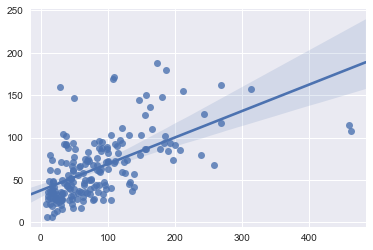

In [100]:
sns.regplot(np.exp(y_test),np.exp(y_hat))

In [101]:
np.corrcoef(np.exp(y_test),np.exp(y_hat))[0,1]

0.5962882547851172

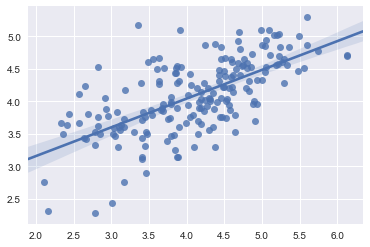

In [62]:
sns.regplot(y_test,y_hat)

In [63]:
np.corrcoef(y_test,y_hat)[0,1]**2

0.4242401375668961

# Gaussian Process

In [56]:
from sklearn.gaussian_process import *

data

In [83]:
ts=np.array(data['Beijing'])
#mu=ts.mean()
#sig=ts.var()

#ts=(ts-mu)/sig

x= np.expand_dims(np.arange(len(ts)),1)
month=np.array(pd.get_dummies(data[['month','weekday']]))


features=data[['Temp.','Pressure','Wind Speed', 'Humidity']]
features=(features-features.mean(axis=0))/features.var(axis=0)
features=np.array(features)

#x=np.hstack([x,features])

In [84]:
train_y = ts[:split]
test_y = ts[split:]

train_X = x[:split]
test_X = x[split:]

In [86]:
y_hat=[]
cov=[]

for i in range(len(ts)-split):
    
    train_y = ts[:split+i]
    train_X = x[:split+i]

    test_y = ts[split+i]
    test_X = x[split+i:split+i+1]
    
    
    gp = GaussianProcessRegressor(normalize_y=True)
    gp.fit(train_X,train_y)

    
    pred,c = gp.predict(test_X,return_cov=True)
    y_hat.append(pred)
    cov.append(c)
    
    #print(gp.X_train_.shape,gp.y_train_.shape)
    
    #gp.X_train_ = np.concatenate([gp.X_train_,test_X[i:i+1]])
    #gp.y_train_ = np.concatenate([gp.y_train_,test_y[i:i+1]])

In [87]:
gp.predict(test_X,return_cov=True)

(array([188.79603007]), array([[0.50442865]]))

In [88]:
test_y = ts[split:]
y_hat=np.stack(y_hat).flatten()
cov=np.stack(cov).flatten()

In [80]:
target=np.exp(test_y*sig+mu)
pred=np.exp(y_hat*sig+mu)
upper=np.exp((y_hat+cov*2)*sig+mu)
lower=np.exp((y_hat-cov*2)*sig+mu)

In [81]:
y_hat.shape,test_y.shape

((199,), (199,))

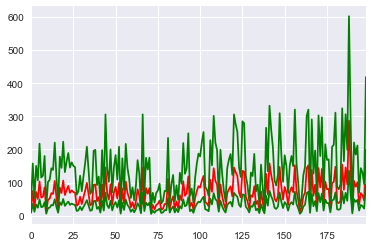

In [82]:
sns.tsplot(pred,color='r')
sns.tsplot(upper,color='g')
sns.tsplot(lower,color='g')

#sns.tsplot(target)

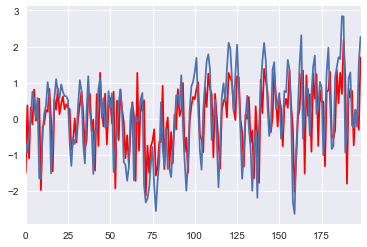

In [37]:
sns.tsplot(y_hat,color='r')
sns.tsplot(test_y)

In [ ]:
sns.regplot(y_hat,test_y)

In [89]:
np.corrcoef(target,pred)[0,1]**2

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [92]:
np.corrcoef(test_y,y_hat)[0,1]

0.610911094809872

In [52]:
r=target-pred

In [53]:
(np.abs(r)).mean()

37.79156227690377

In [54]:
test_y.shape,y_hat.shape

((199,), (199,))

In [ ]:
sns.regplot(r,features[split:,3])

In [ ]:
np.concatenate([train_X,test_X[0:1]]).shape,train_X.shape

In [ ]:
np.concatenate([gp.y_train_,test_y[0:1]]).shape,gp.y_train_.shape

In [55]:
from sklearn.metrics import r2_score

r2_score(target,pred)

0.3766345240097906

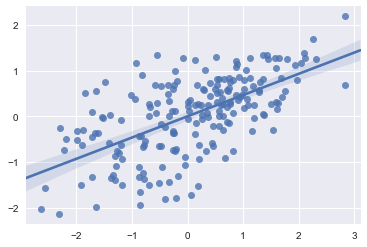

In [46]:
sns.regplot(test_y,y_hat)

In [102]:
np.sqrt(.42)

0.648074069840786